In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import pickle

In [2]:
# Get data
orbis = pd.read_csv('../data_collection/orbis_clean.csv')
orbis = orbis.drop('Unnamed: 0', axis=1)
gd = pd.read_csv('../reviews/all_df.csv')
gd = gd.drop('Unnamed: 0', axis=1)
industries = pd.read_csv('../data_collection/industries.csv')
industries = industries.drop('Unnamed: 0', axis=1)

<ipython-input-2-223cfa39998f>:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  gd = pd.read_csv('../reviews/all_df.csv')


In [3]:
industries = industries.rename(columns={"Nom de l'entreprise Latin alphabet": 'name',
                                       'Numéro Orbis': 'orbis_nbr',
                                       'BvD sectors': 'bvd_sector',
                                       'Code SIC (US) Code(s) Primaire(s)': 'primary_sic',
                                       'US SIC Principal, description textuelle': 'primary_sic_txt',
                                       'Code SIC (US) Code(s) Secondaire(s)': 'secundary_sic',
                                       'US SIC secondaire, description textuelle': 'secundary_sic_txt'})

In [4]:
# Exclude companies with less than 30 reviews
count_companies = gd.groupby('orbis_name')['review_id'].count()
gd = gd[gd['orbis_name'].isin(count_companies[count_companies >= 30].index)]

In [5]:
# Complete dataset
# Merge financial and reviews and classification
orbis_gd = pd.merge(orbis, gd, left_on='name', right_on='orbis_name')
orbis_gd = pd.merge(orbis_gd, industries, on='orbis_nbr')

In [6]:
# Developement dataset!
#orbis_gd = orbis_gd.sample(frac =.10)

In [7]:
orbis_gd.shape

(567044, 251)

In [8]:
# Convert certain columns to numeric
def numerize_friend(string):
    if string == '"NEGATIVE"':
        return -1
    elif string == '"POSITIVE"':
        return 1
    else:
        return np.nan
    
def numerize_ceo(string):
    if string == '"DISAPPROVE"':
        return -1
    elif string == '"APPROVE"':
        return 1
    else:
        return np.nan
    
def numerize_outlook(string):
    if string == '"NEUTRAL"':
        return 0
    elif string == '"POSITIVE"':
        return 1
    elif string == '"NEGATIVE"':
        return -1
    else:
        return np.nan
    
orbis_gd['rating_recommend_friend'] = orbis_gd['rating_recommend_friend'].apply(numerize_friend)
orbis_gd['rating_ceo'] = orbis_gd['rating_ceo'].apply(numerize_ceo)
orbis_gd['rating_businessoutlook'] = orbis_gd['rating_businessoutlook'].apply(numerize_outlook)

In [9]:
# Remove industries with less than 1000 reviews
sector_counts = orbis_gd.groupby('bvd_sector')['review_id'].count()

to_remove = sector_counts[sector_counts < 1000]
to_remove.index
orbis_gd = orbis_gd[~orbis_gd['bvd_sector'].isin(to_remove.index)]

### Basic exploration

In [10]:
orbis_gd.shape

(566343, 251)

In [11]:
# Convert the Timestamp column to datetime format
orbis_gd['review_datetime'] = pd.to_datetime(orbis_gd['review_datetime'])

# Enough rating from mid 2016, remove before
orbis_gd = orbis_gd[orbis_gd['review_datetime'] > datetime(2017, 6, 1)]

# Diversity and inclusion starts only in mid 2020
orbis_gd.loc[orbis_gd['review_datetime'] < datetime(2021, 1, 1), 'rating_diversity_inclusion'] = np.nan

In [12]:
# Parsing went wrong for 237 - 6 = 231 reviews
print(len(orbis_gd['review_overall'].unique()))

# convert non-numeric values to NaN
orbis_gd['review_overall'] = pd.to_numeric(orbis_gd['review_overall'], errors='coerce')

# replace NaN values with a specific value, if desired
orbis_gd['review_overall'].fillna(value=np.nan, inplace=True)

print(len(orbis_gd['review_overall'].unique()))


237
6


### Distribution of industries

In [13]:
# get sample data for chatgpt
#orbis_gd[:2].to_dict()

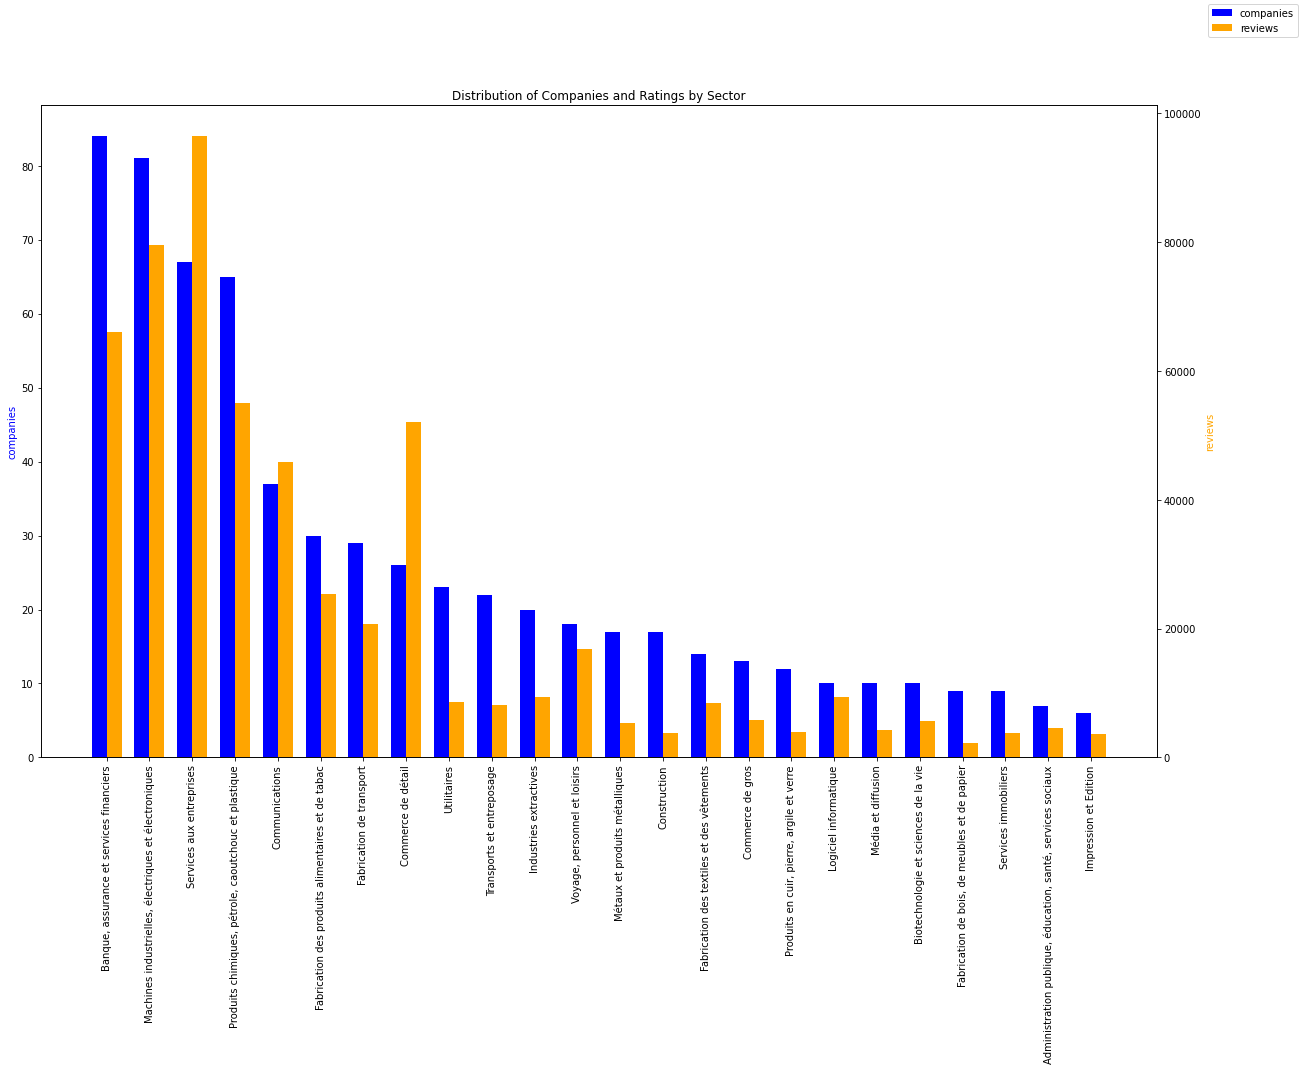

In [14]:
companies_per_sector = orbis_gd.groupby('bvd_sector')['name_x'].nunique().sort_values(ascending=False)
reviews_per_sector = orbis_gd.groupby('bvd_sector')['orbis_nbr'].count().reindex(companies_per_sector.index)

fig, ax1 = plt.subplots(figsize=(20, 12))

# set the width of each bar
width = 0.35

# create a range of x-values for the first bar chart
x1 = np.arange(len(companies_per_sector.index))

# plot the first bar chart
ax1.bar(x1, companies_per_sector.values, color='blue', width=width, label='companies')

# set the x-tick labels for the first bar chart
ax1.set_xticks(x1)
ax1.set_xticklabels(companies_per_sector.index, rotation=90)

# set the y-axis label for the first bar chart
ax1.set_ylabel('companies', color='blue')

# create a range of x-values for the second bar chart, shifted by the width of each bar
x2 = x1 + width

# plot the second bar chart
ax2 = ax1.twinx()
ax2.bar(x2, reviews_per_sector.values, color='orange', width=width, label='reviews')

# set the x-tick labels for the second bar chart
ax2.set_xticks(x1 + width/2)
ax2.set_xticklabels(reviews_per_sector.index, rotation=90)

# set the y-axis label for the second bar chart
ax2.set_ylabel('reviews', color='orange')

# add legend
fig.legend()
#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

plt.title('Distribution of Companies and Ratings by Sector')

plt.show()


### Ratings over time global

In [15]:
monthly_ratings = orbis_gd.groupby(pd.Grouper(key='review_datetime', freq='M'))['rating_worklifebalance',
                                                                        'rating_culture_values',
                                                                        'rating_diversity_inclusion',
                                                                        'rating_senior_leadership',
                                                                        'rating_career_opport',
                                                                        'rating_compensation_benefits'].mean()
# Enough rating from mid 2016, remove before
monthly_ratings = monthly_ratings[monthly_ratings.index > datetime(2017, 6, 1)]

# Diversity and inclusion starts only in mid 2020
monthly_ratings.loc[monthly_ratings.index < datetime(2021, 1, 1), 'rating_diversity_inclusion'] = np.nan

<ipython-input-15-4ca51bb4510e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  monthly_ratings = orbis_gd.groupby(pd.Grouper(key='review_datetime', freq='M'))['rating_worklifebalance',


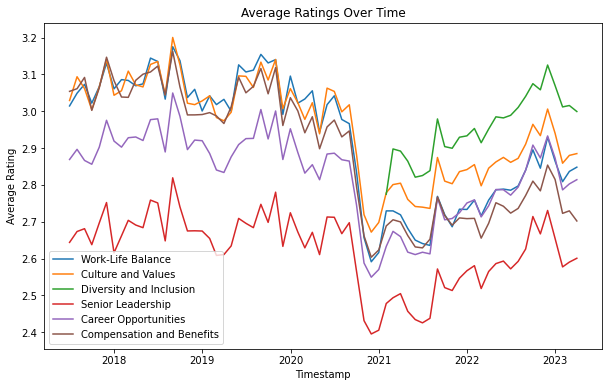

In [16]:
# Plot the average ratings over time using a line plot

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_ratings.index, monthly_ratings['rating_worklifebalance'], label='Work-Life Balance')
ax.plot(monthly_ratings.index, monthly_ratings['rating_culture_values'], label='Culture and Values')
ax.plot(monthly_ratings.index, monthly_ratings['rating_diversity_inclusion'], label='Diversity and Inclusion')
ax.plot(monthly_ratings.index, monthly_ratings['rating_senior_leadership'], label='Senior Leadership')
ax.plot(monthly_ratings.index, monthly_ratings['rating_career_opport'], label='Career Opportunities')
ax.plot(monthly_ratings.index, monthly_ratings['rating_compensation_benefits'], label='Compensation and Benefits')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratings Over Time')
ax.legend()
plt.show()

## Rating by industry over time

In [17]:
ratings = ['rating_worklifebalance',
        'rating_culture_values',
        'rating_diversity_inclusion',
        'rating_senior_leadership',
        'rating_career_opport',
        'rating_compensation_benefits']

In [18]:
sectors = orbis_gd['bvd_sector'].unique()

In [19]:
monthly_average_industry = {}
for sector in sectors:
    sector_data = orbis_gd[orbis_gd['bvd_sector'] == sector]
    monthly_average_industry[sector] = sector_data.groupby(pd.Grouper(key='review_datetime', freq='M'))[ratings].mean()

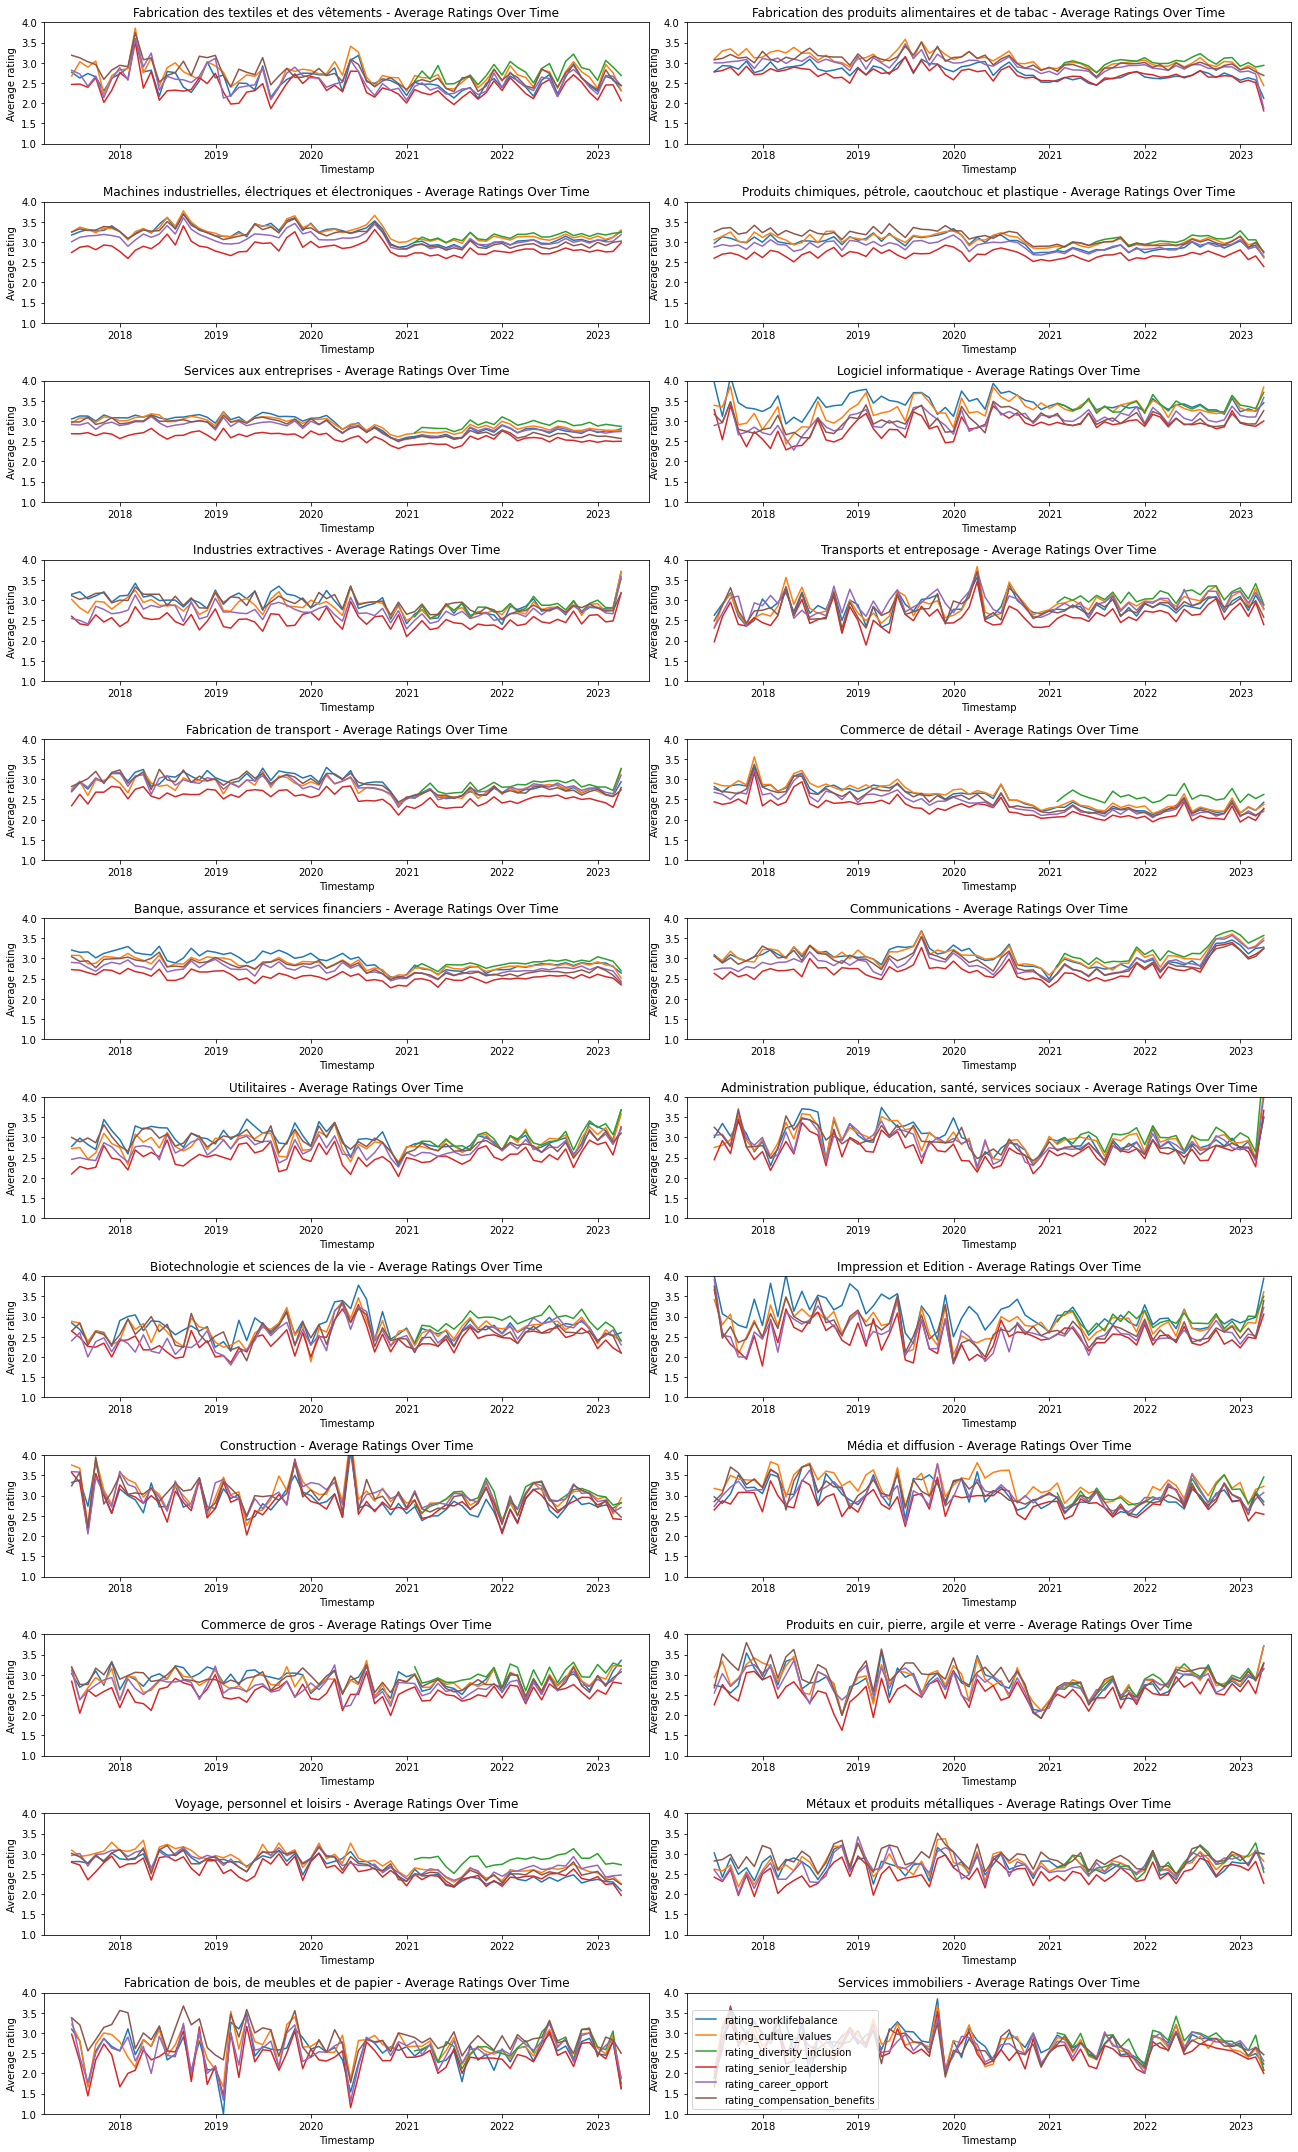

In [20]:
fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(18, 30))

for rating in ratings:
    for i, sector in enumerate(sectors):
        row = i // 2
        col = i % 2
        ax = axs[row, col]
        
        ax.plot(monthly_average_industry[sector].index, monthly_average_industry[sector][rating], label=rating)
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Average rating')
        ax.set_title(f'{sector} - Average Ratings Over Time')
        ax.set_ylim(1, 4)
ax.legend()
plt.tight_layout()
plt.show()


A lot of collinearity.

In [21]:
orbis_gd['bvd_sector'].value_counts()

Services aux entreprises                                       96438
Machines industrielles, électriques et électroniques           79594
Banque, assurance et services financiers                       66008
Produits chimiques, pétrole, caoutchouc et plastique           54989
Commerce de détail                                             52063
Communications                                                 45895
Fabrication des produits alimentaires et de tabac              25432
Fabrication de transport                                       20740
Voyage, personnel et loisirs                                   16827
Logiciel informatique                                           9414
Industries extractives                                          9304
Utilitaires                                                     8671
Fabrication des textiles et des vêtements                       8453
Transports et entreposage                                       8203
Commerce de gros                  

Does not seem to be due by insufficent sample size.

Let's get this information into a table:

## For each industry, each rating take the 90 and 10th percentile and get the difference to see for each period each indsutry how this went

In [22]:
def get_period(date):
    if datetime(2021, 8, 1) >= date >= datetime(2020, 3, 18):
        return 2
    elif datetime(2021, 8, 1) < date:
        return 3
    else:
        return 1

In [23]:
orbis_gd['period'] = orbis_gd['review_datetime'].apply(get_period)

In [24]:
# Get average rating by company by period
review_period = orbis_gd.groupby(['orbis_name', 'bvd_sector', 'period'])['review_overall'].agg(['mean', 'count'])

In [25]:
review_period

mean  \
orbis_name                bvd_sector                               period             
3I GROUP PLC              Banque, assurance et services financiers 1       3.937500   
                                                                   2       4.000000   
                                                                   3       4.375000   
A P MOLLER-MAERSK A/S     Transports et entreposage                2       4.048643   
                                                                   3       4.158699   
...                                                                             ...   
ZALANDO SE                Commerce de détail                       2       3.929360   
                                                                   3       3.891348   
ZURICH INSURANCE GROUP AG Banque, assurance et services financiers 1       2.952381   
                                                                   2       3.562500   
                                                                   3       3.172414   

                                                                           count  
orbis_name                bvd_sector                               period         
3I GROUP PLC              Banque, assurance et services financiers 1          16  
                                                                   2           7  
                                                                   3          16  
A P MOLLER-MAERSK A/S     Transports et entreposage                2         884  
                                                                   3        1506  
...                                                                          ...  
ZALANDO SE                Commerce de détail                       2         453  
                                                                   3         497  
ZURICH INSURANCE GROUP AG Banque, assurance et services financiers 1          21  
                                                                   2          16  
                                                                   3          29  

[1833 rows x 2 columns]

In [26]:
# Remove if too little reviews in a given period
review_period = review_period[review_period['count'] > 20]

In [27]:
# Companies by industry
company_counts = review_period.groupby('bvd_sector').size().rename('Company Count')

In [28]:
# Build df with 90-10th and 75-25th company rating percentile within each industry for each period
variability_desc = review_period.pivot_table(values='mean', 
                                             index='bvd_sector', 
                                             columns='period', 
                                             aggfunc=lambda x: ((np.percentile(x, 90) - np.percentile(x, 10)).round(2), 
                                                                (np.percentile(x, 75) - np.percentile(x, 25)).round(2)))
variability_desc = variability_desc.rename(columns={1: 'Pre-lockdown (90th-10th, 75th-25th)', 2: 'During lockdown', 3: 'Post-lockdown'})

In [29]:
variability = variability_desc.merge(company_counts, left_index=True, right_index=True)
variability.sort_values('Company Count', ascending=False)

Pre-lockdown (90th-10th, 75th-25th)  \
bvd_sector                                                                               
Machines industrielles, électriques et électron...                        (1.03, 0.69)   
Banque, assurance et services financiers                                  (0.85, 0.46)   
Services aux entreprises                                                   (0.94, 0.5)   
Produits chimiques, pétrole, caoutchouc et plas...                         (0.76, 0.4)   
Communications                                                            (0.94, 0.48)   
Fabrication de transport                                                  (0.67, 0.42)   
Fabrication des produits alimentaires et de tabac                          (0.9, 0.44)   
Commerce de détail                                                        (0.91, 0.32)   
Transports et entreposage                                                 (1.08, 0.69)   
Utilitaires                                                               (0.59, 0.41)   
Voyage, personnel et loisirs                                              (0.94, 0.59)   
Industries extractives                                                    (0.55, 0.35)   
Métaux et produits métalliques                                             (0.5, 0.22)   
Fabrication des textiles et des vêtements                                  (0.79, 0.6)   
Construction                                                              (1.15, 0.39)   
Commerce de gros                                                           (0.6, 0.16)   
Produits en cuir, pierre, argile et verre                                 (0.68, 0.52)   
Logiciel informatique                                                      (1.04, 0.4)   
Média et diffusion                                                        (0.62, 0.21)   
Fabrication de bois, de meubles et de papier                              (0.68, 0.28)   
Administration publique, éducation, santé, serv...                         (0.48, 0.2)   
Impression et Edition                                                     (0.66, 0.52)   
Services immobiliers                                                      (0.86, 0.71)   
Biotechnologie et sciences de la vie                                      (0.37, 0.23)   

                                                   During lockdown  \
bvd_sector                                                           
Machines industrielles, électriques et électron...    (0.81, 0.43)   
Banque, assurance et services financiers               (0.55, 0.3)   
Services aux entreprises                              (0.85, 0.32)   
Produits chimiques, pétrole, caoutchouc et plas...    (0.53, 0.28)   
Communications                                         (0.8, 0.49)   
Fabrication de transport                              (0.85, 0.39)   
Fabrication des produits alimentaires et de tabac     (0.63, 0.41)   
Commerce de détail                                    (1.02, 0.36)   
Transports et entreposage                             (0.76, 0.43)   
Utilitaires                                           (0.69, 0.38)   
Voyage, personnel et loisirs                          (0.69, 0.52)   
Industries extractives                                (0.54, 0.23)   
Métaux et produits métalliques                         (0.5, 0.36)   
Fabrication des textiles et des vêtements             (0.51, 0.33)   
Construction                                          (1.07, 0.65)   
Commerce de gros                                      (0.58, 0.37)   
Produits en cuir, pierre, argile et verre             (0.52, 0.26)   
Logiciel informatique                                 (0.55, 0.28)   
Média et diffusion                                    (0.67, 0.44)   
Fabrication de bois, de meubles et de papier          (0.82, 0.41)   
Administration publique, éducation, santé, serv...    (0.85, 0.61)   
Impression et Edition                                 (0.73, 0.37)   
Services immobiliers          

Table showing number of firms, number of reviews, mean, median, max and min. amount of reviews and decide at how much to exclude

In [30]:
descriptable = orbis_gd.groupby('bvd_sector').agg(
                        review_count = ('review_id', 'count'),
                        company_count = ('name_x', 'nunique'),
                        avg_overall = ('review_overall', 'mean'),
                        avg_worklife_balance = ('rating_worklifebalance', 'mean'),
                        avg_culture_values = ('rating_culture_values', 'mean'),
                        avg_diversity_inclusion = ('rating_diversity_inclusion', 'mean'),
                        avg_senior_leadership = ('rating_senior_leadership', 'mean'),
                        avg_career_opportunities = ('rating_career_opport', 'mean'),
                        avg_compensation_benefits = ('rating_compensation_benefits', 'mean'),
                        avg_friend_recommendation = ('rating_recommend_friend', 'mean'),
                        avg_ceo = ('rating_ceo', 'mean'),
                        avg_businessoutlook = ('rating_businessoutlook', 'mean')).sort_values(by=['review_count'], ascending=False)
descriptable

review_count  \
bvd_sector                                                         
Services aux entreprises                                   96438   
Machines industrielles, électriques et électron...         79594   
Banque, assurance et services financiers                   66008   
Produits chimiques, pétrole, caoutchouc et plas...         54989   
Commerce de détail                                         52063   
Communications                                             45895   
Fabrication des produits alimentaires et de tabac          25432   
Fabrication de transport                                   20740   
Voyage, personnel et loisirs                               16827   
Logiciel informatique                                       9414   
Industries extractives                                      9304   
Utilitaires                                                 8671   
Fabrication des textiles et des vêtements                   8453   
Transports et entreposage                                   8203   
Commerce de gros                                            5774   
Biotechnologie et sciences de la vie                        5613   
Métaux et produits métalliques                              5316   
Administration publique, éducation, santé, serv...          4589   
Média et diffusion                                          4238   
Produits en cuir, pierre, argile et verre                   3974   
Construction                                                3835   
Services immobiliers                                        3728   
Impression et Edition                                       3607   
Fabrication de bois, de meubles et de papier                2229   

                                                    company_count  \
bvd_sector                                                          
Services aux entreprises                                       67   
Machines industrielles, électriques et électron...             81   
Banque, assurance et services financiers                       84   
Produits chimiques, pétrole, caoutchouc et plas...             65   
Commerce de détail                                             26   
Communications                                                 37   
Fabrication des produits alimentaires et de tabac              30   
Fabrication de transport                                       29   
Voyage, personnel et loisirs                                   18   
Logiciel informatique                                          10   
Industries extractives                                         20   
Utilitaires                                                    23   
Fabrication des textiles et des vêtements                      14   
Transports et entreposage                                      22   
Commerce de gros                                               13   
Biotechnologie et sciences de la vie                           10   
Métaux et produits métalliques                                 17   
Administration publique, éducation, santé, serv...              7   
Média et diffusion                                             10   
Produits en cuir, pierre, argile et verre                      12   
Construction                                                   17   
Services immobiliers                                            9   
Impression et Edition                                           6   
Fabrication de bois, de meubles et de papier                    9   

                                                    avg_overall  \
bvd_sector                                                        
Services aux entreprises                               3.741399   
Machines industrielles, électriques et électron...     3.932332   
Banque, assurance et services financiers               3.755371   
Produits chimiques, pétrole, caoutchouc et plas...     3.863500   
Commerce de détail                                     3.614390   
Communications     

Identify bigrams in different industries in pre, during and post pandemic (use spacy) word cloud
Part of speech check dm notebook
Correlations between ratings and financials
4 part diagram with count high ratings good financialsm and other combinations as a teaser




## Text

In [31]:
# # Combine pros and cons columns into a single text column
# text = pd.DataFrame()
# text['rating'] = orbis_gd['review_overall']
# text['pros'] = orbis_gd['pros']
# text['cons'] = orbis_gd['cons']
# text['text'] = text['pros'] + ' ' + text['cons']
# text['period'] = orbis_gd['period']

# # Drop rows with missing values
# text.dropna(inplace=True)

# import string
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer

# def normalize_text(doc):
#     # Remove newlines and carriage returns
#     doc = doc.replace('\r', ' ').replace('\n', ' ')

#     # Convert to lowercase
#     lower = doc.lower()

#     # Remove punctuation
#     no_punct = lower.translate(str.maketrans('', '', string.punctuation))

#     # Tokenize the text
#     tokens = word_tokenize(no_punct)

#     # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

#     # Lemmatization
#     lemmatizer = WordNetLemmatizer()
#     lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

#     # Join the lemmatized tokens into a single string
#     normalized_text = ' '.join(lemmatized_tokens)

#     return normalized_text

# # Normalize
# text['pros_lemma'] = text['pros'].apply(normalize_text)
# text['cons_lemma'] = text['cons'].apply(normalize_text)

file_path = 'text2.pickle'
# # Write pickle
# with open(file_path, 'wb') as f:
#     pickle.dump(text, f)
# Read pickle
with open(file_path, 'rb') as f:
    text = pickle.load(f)

In [32]:
text.head()

rating                                               pros  \
0     3.0                   Four days a week Lunch allowance   
1     4.0            Good package , nice working environment   
2     3.0  It’s a good place for learning about how to do...   
3     4.0  Good employee benefits Company training Year e...   
4     5.0  Great management. Beautiful products. Excellen...   

                                                cons  \
0               long hours Long days Poor management   
1      Manual works, not have much systematic system   
2                    Too much politics and formality   
3             Limited Salary increment for employees   
4  There are only a few cons. Mainly in Nottingha...   

                                                text  period  \
0  Four days a week Lunch allowance long hours Lo...       3   
1  Good package , nice working environment Manual...       3   
2  It’s a good place for learning about how to do...       3   
3  Good employee benefits Company training Year e...       3   
4  Great management. Beautiful products. Excellen...       3   

                                          pros_lemma  \
0                      four day week lunch allowance   
1              good package nice working environment   
2  ’ good place learning presentation ’ make diff...   
3  good employee benefit company training year en...   
4  great management beautiful product excellent t...   

                                          cons_lemma  
0                 long hour long day poor management  
1                 manual work much systematic system  
2                            much politics formality  
3                  limited salary increment employee  
4  con mainly nottingham would great givenchy ski...

In [33]:
from nltk import ngrams

# Join the lemmatized pros into a single string
pros_text_p1 = ' '.join(text['pros_lemma'][text['period'] == 1])
pros_text_p2 = ' '.join(text['pros_lemma'][text['period'] == 2])
pros_text_p3 = ' '.join(text['pros_lemma'][text['period'] == 3])
cons_text_p1 = ' '.join(text['cons_lemma'][text['period'] == 1])
cons_text_p2 = ' '.join(text['cons_lemma'][text['period'] == 2])
cons_text_p3 = ' '.join(text['cons_lemma'][text['period'] == 3])


# Extract grams and bigrams
all_grams = {'grams_pros_p1': ngrams(pros_text_p1.split(), 1),
            'grams_cons_p1': ngrams(cons_text_p1.split(), 1),
            'bigrams_pros_p1': ngrams(pros_text_p1.split(), 2),
            'bigrams_cons_p1': ngrams(cons_text_p1.split(), 2),
            'trigrams_pros_p1': ngrams(pros_text_p1.split(), 3),
            'trigrams_cons_p1': ngrams(cons_text_p1.split(), 3),
            'grams_pros_p2': ngrams(pros_text_p2.split(), 1),
            'grams_cons_p2': ngrams(cons_text_p2.split(), 1),
            'bigrams_pros_p2': ngrams(pros_text_p2.split(), 2),
            'bigrams_cons_p2': ngrams(cons_text_p2.split(), 2),
            'trigrams_pros_p2': ngrams(pros_text_p2.split(), 3),
            'trigrams_cons_p2': ngrams(cons_text_p2.split(), 3),
            'grams_pros_p3': ngrams(pros_text_p3.split(), 1),
            'grams_cons_p3': ngrams(cons_text_p3.split(), 1),
            'bigrams_pros_p3': ngrams(pros_text_p3.split(), 2),
            'bigrams_cons_p3': ngrams(cons_text_p3.split(), 2),
            'trigrams_pros_p3': ngrams(pros_text_p3.split(), 3),
            'trigrams_cons_p3': ngrams(cons_text_p3.split(), 3)}

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot wordcloud
def plot_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(dict(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Create grams and bigrams wordclouds for pros
def list_to_wordcloud(plot_name, grams):
    grams_dict = dict()
    for gram in grams:
        gram_str = ' '.join(gram)  # Convert the tuple to a string
        if gram_str in grams_dict:
            grams_dict[gram_str] += 1
        else:
            grams_dict[gram_str] = 1
    
    plot_wordcloud(grams_dict, f'{plot_name} Grams Wordcloud')
    return grams_dict

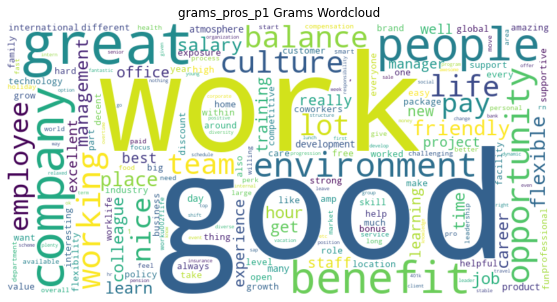

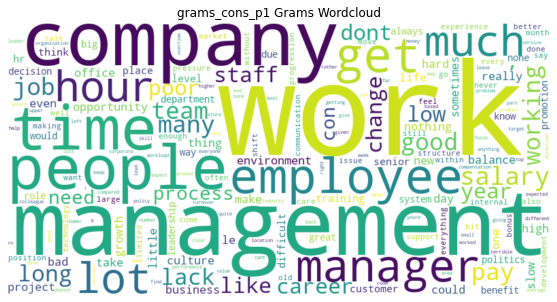

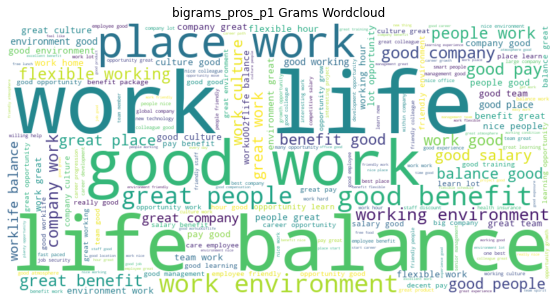

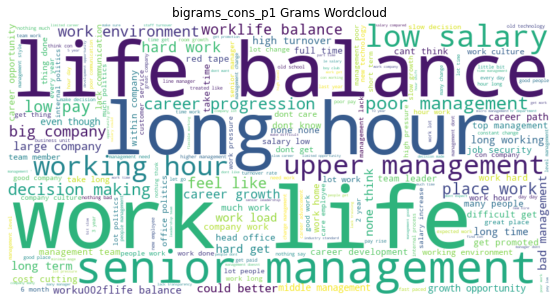

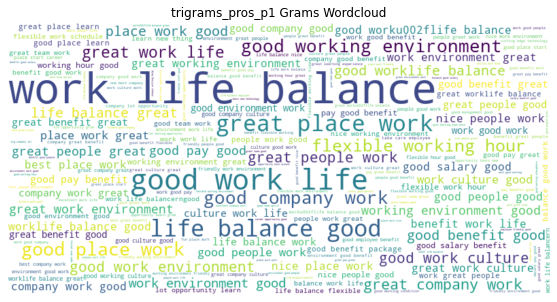

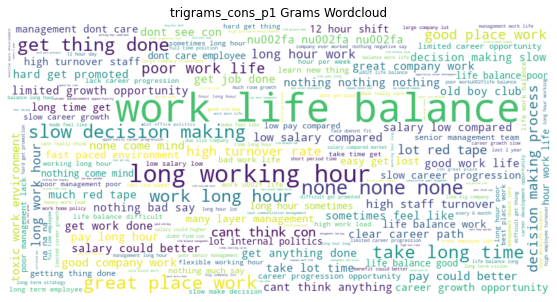

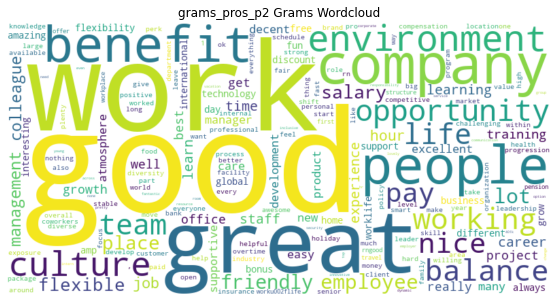

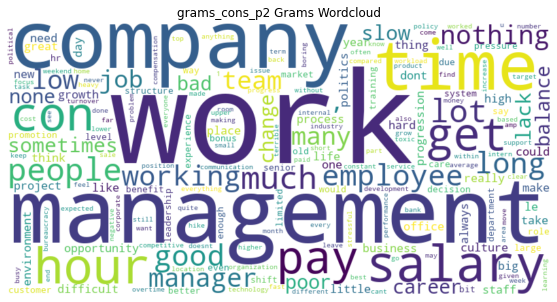

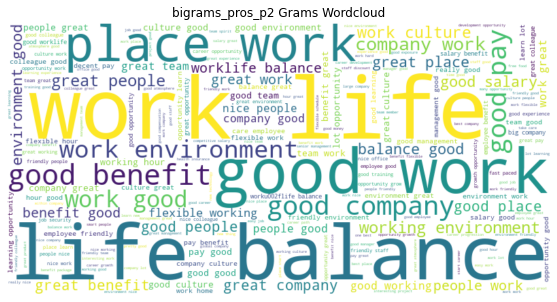

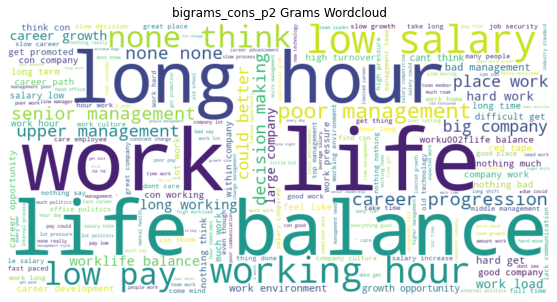

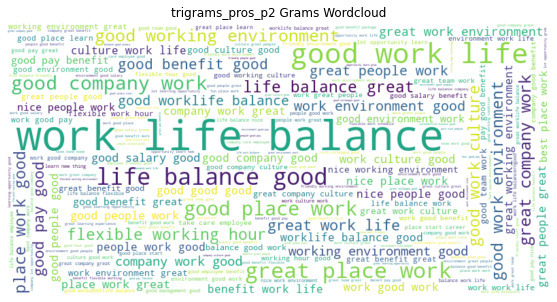

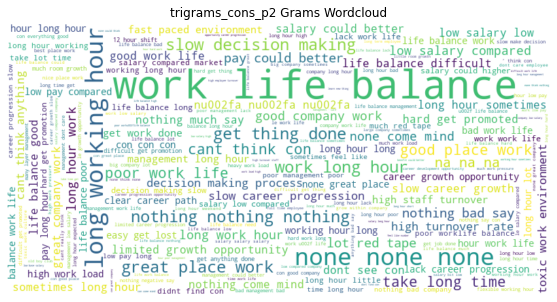

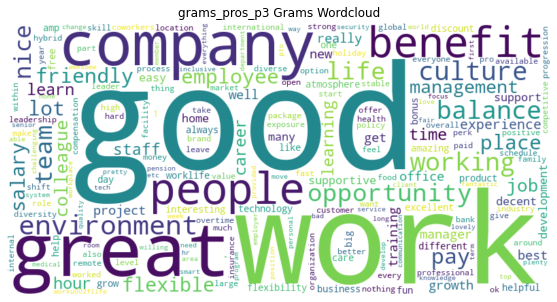

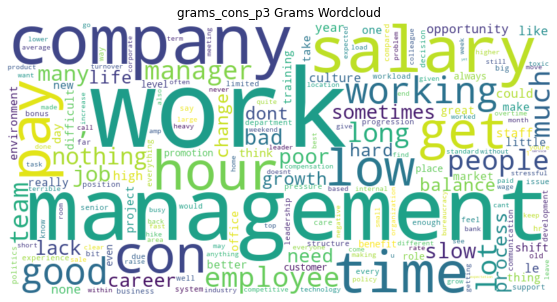

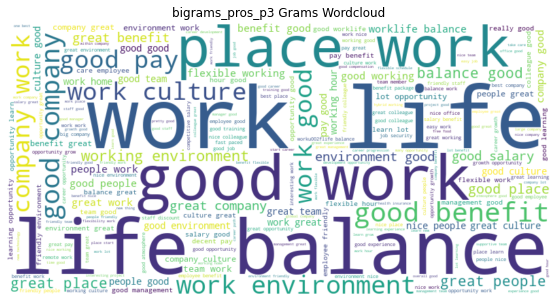

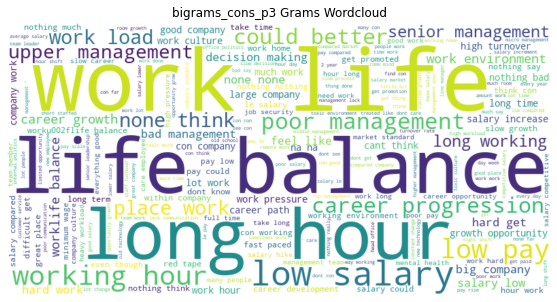

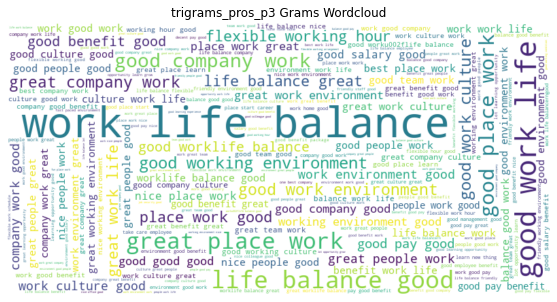

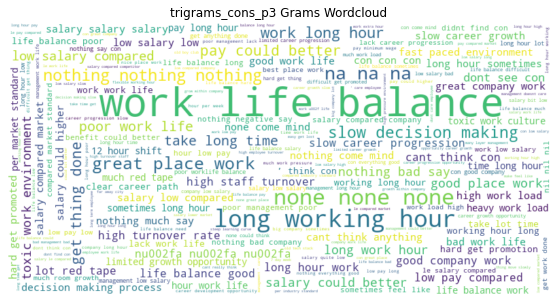

In [35]:
all_grams_counts = dict()
for key, value in all_grams.items():
    all_grams_counts[f'{key}_counts'] = list_to_wordcloud(key, value)

In [36]:
import collections

# Get the 500 most frequent words
top500_grams_counts = dict()
for key, value in all_grams_counts.items():
    top500_grams_counts[key] = dict(collections.Counter(value).most_common(250))

In [37]:
# Select the grams for the lasso regression
# Let's not use the unigrams as they never mean much
unique_grams = set()
unigrams = ('grams_pros_p1_counts', 
              'grams_cons_p1_counts',
              'grams_pros_p2_counts', 
              'grams_cons_p2_counts',
              'grams_pros_p3_counts', 
              'grams_cons_p3_counts')

for key, counts in top500_grams_counts.items():
    if key not in unigrams:
        for gram_name in counts.keys():
            unique_grams.add(gram_name)

In [38]:
selected_grams = list(unique_grams)
len(selected_grams)

1204

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [40]:
# ## Best param is 0.0001
# from sklearn.model_selection import GridSearchCV
# param_grid = {'alpha': [0.001 ,0.0001, 0.005]}  
# lasso = Lasso()
# grid_search = GridSearchCV(lasso, param_grid, cv=2)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_


In [41]:
# # Initialize CountVectorizer with selected grams
# vectorizer = CountVectorizer(ngram_range=(2, 3), vocabulary=selected_grams)

# # Transform pros and cons text into occurrence counts
# pros_counts = vectorizer.fit_transform(text['pros_lemma'])
# cons_counts = vectorizer.fit_transform(text['cons_lemma'])

# # Concatenate pros and cons occurrence counts, multiplying cons by -1
# X = pd.concat([pd.DataFrame(pros_counts.toarray()), pd.DataFrame(cons_counts.toarray() * -1)], axis=1)

# # Assign the rating column as the target variable
# y = text['rating']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize Lasso model with alpha value
# lasso = Lasso(alpha=0.0001)

# # Fit the Lasso model on the training data
# lasso.fit(X_train, y_train)

# # Predict ratings using the trained model
# y_pred = lasso.predict(X_test)

# # Calculate mean squared error to evaluate the model's performance
# mse = mean_squared_error(y_test, y_pred)

In [42]:
# mse

In [43]:
# # Get the feature names from the vectorizer
# feature_names = vectorizer.get_feature_names()

# # Get the coefficients from the Lasso model
# coefficients = lasso.coef_

# # Create a dictionary mapping feature names to coefficients
# feature_coefficients = dict(zip(feature_names, coefficients))

# # Create a DataFrame from the feature_coefficients dictionary
# df_coefficients = pd.DataFrame.from_dict(feature_coefficients, orient='index', columns=['Coefficient'])

# # Set the index name of the DataFrame as 'Feature'
# df_coefficients.index.name = 'Feature'

# # Filter the DataFrame to include only non-zero coefficient features
# df_valuable_coeffs = df_coefficients[df_coefficients['Coefficient'] != 0]


In [44]:
file_path = 'important_features.pickle'
# # Write pickle
# with open(file_path, 'wb') as f:
#     pickle.dump(df_valuable_coeffs, f)
# # Read pickle
with open(file_path, 'rb') as f:
    df_valuable_coeffs = pickle.load(f)
df_valuable_coeffs

Coefficient
Feature                              
great good                   0.040060
good salary                  0.117199
good people good             0.131001
new employee                 0.007838
good working environment    -0.062489
...                               ...
people nice                 -0.083874
work place                   0.151933
nothing much                -0.733549
great brand                 -0.001313
leadership team              0.373000

[330 rows x 1 columns]

In [45]:
# Ok but let's see which are significant with an OLS approximation
import statsmodels.api as sm

# Initialize CountVectorizer with only valuable features
vectorizer = CountVectorizer(ngram_range=(2, 3), vocabulary=df_valuable_coeffs.index)

# Transform pros and cons text into occurrence counts
pros_counts = vectorizer.fit_transform(text['pros_lemma'])
cons_counts = vectorizer.fit_transform(text['cons_lemma'])

# Concatenate pros and cons occurrence counts, multiplying cons by -1
X = pd.concat([pd.DataFrame(pros_counts.toarray()), pd.DataFrame(cons_counts.toarray() * -1)], axis=1)

# Assign the rating column as the target variable
y = text['rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset the indices of X_train and y_train to ensure alignment
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

ols = sm.OLS(y_train, sm.add_constant(X_train))
ols_results = ols.fit()

p_values = ols_results.pvalues

In [50]:
# # Convert p-values to percentages with two decimal places
# p_values_pros_perc = p_values[1:331] * 100
# p_values_cons_perc = p_values[331:] * 100

# # Create a DataFrame for the gram names, coefficients, and p-values
# result_df = pd.DataFrame({'Gram': vectorizer.get_feature_names_out(),
#                           'Coefficient pros': ols_results.params[1:331].values,
#                           'Coefficient cons': ols_results.params[331:].values,
#                           'p-value_pros': p_values_pros_perc.values,
#                           'p-value_cons': p_values_cons_perc.values,
#                           'lasso coefficient': df_valuable_coeffs['Coefficient']})

# # Format p-values as percentages with two decimal places
# result_df['p-value_pros'] = result_df['p-value_pros'].map("{:.2f}%".format)
# result_df['p-value_cons'] = result_df['p-value_cons'].map("{:.2f}%".format)

# file_path = 'important_features_p_values.pickle'
# # Write pickle
# with open(file_path, 'wb') as f:
#     pickle.dump(result_df, f)
# Read pickle
with open(file_path, 'rb') as f:
    result_df = pickle.load(f)

# Print the DataFrame
result_df

Gram  Coefficient pros  \
Feature                                                                
great good                              great good          0.227875   
good salary                            good salary          0.149069   
good people good                  good people good          0.222205   
new employee                          new employee          0.238735   
good working environment  good working environment         -0.148566   
...                                            ...               ...   
people nice                            people nice         -0.170188   
work place                              work place          0.196165   
nothing much                          nothing much         -0.996485   
great brand                            great brand         -0.079957   
leadership team                    leadership team          0.464063   

                          Coefficient cons p-value_pros p-value_cons  \
Feature                                                                
great good                       -0.024348        0.19%       92.81%   
good salary                       0.099630        0.00%        8.11%   
good people good                 -0.599481        0.00%        5.76%   
new employee                      0.548092        0.25%        0.00%   
good working environment         -0.601503        0.00%        0.29%   
...                                    ...          ...          ...   
people nice                       0.222810        0.00%       12.28%   
work place                        0.293912        0.00%        0.00%   
nothing much                     -0.334343        0.00%        0.00%   
great brand                       0.231263        6.76%       43.84%   
leadership team                   0.665428        0.00%        0.00%   

                          lasso coefficient  
Feature                                      
great good                         0.040060  
good salary                        0.117199  
good people good                   0.131001  
new employee                       0.007838  
good working environment          -0.062489  
...                                     ...  
people nice                       -0.083874  
work place                         0.151933  
nothing much                      -0.733549  
great brand                       -0.001313  
leadership team                    0.373000  

[330 rows x 6 columns]

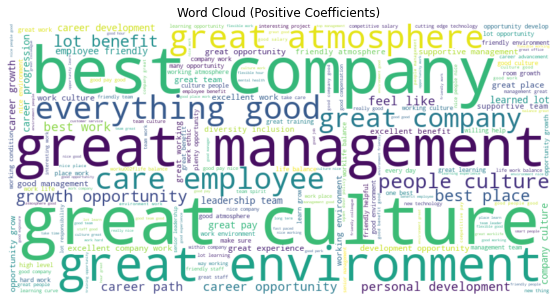

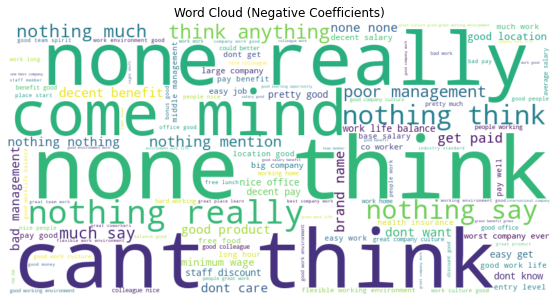

In [51]:
# Filter positive coefficients
positive_coeffs = df_valuable_coeffs[df_valuable_coeffs['Coefficient'] > 0]['Coefficient']

# Filter negative coefficients
negative_coeffs = df_valuable_coeffs[df_valuable_coeffs['Coefficient'] < 0]['Coefficient']

# Normalize positive coefficient sizes
positive_sizes = positive_coeffs.abs() / positive_coeffs.abs().max()

# Normalize negative coefficient sizes
negative_sizes = negative_coeffs.abs() / negative_coeffs.abs().max()

# Create word cloud for positive coefficients
positive_wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(positive_sizes)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Positive Coefficients)')
plt.show()

# Create word cloud for negative coefficients
negative_wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(negative_sizes)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Negative Coefficients)')
plt.show()
